# Dive into the Competition
> Now that you know the basics of Kaggle competitions, you will learn how to study the specific problem at hand. You will practice EDA and get to establish correct local validation strategies. You will also learn about data leakage. This is the Summary of lecture "Winning a Kaggle Competition in Python", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Kaggle, Machine_Learning]
- image: images/stratified_kfold.png

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize']=(10, 8)

## Understand the problem
- Solution workflow
![sw](image/solution_workflow.png)
- Custom Metric (Root Mean Squared Error in a Logarithmic scale)
$$ RMSLE = \sqrt{\frac{1}{N}\sum_{i=1}^N (\log(y_i + 1) - \log(\hat{y_i} + 1))^2} $$

### Define a competition metric
Competition metric is used by Kaggle to evaluate your submissions. Moreover, you also need to measure the performance of different models on a local validation set.

For now, your goal is to manually develop a couple of competition metrics in case if they are not available in `sklearn.metrics`.

In particular, you will define:

- Mean Squared Error (MSE) for the regression problem:

$$ MSE = \frac{1}{N} \sum_{i=1}^{N}(y_i - \hat{y_i})^2 $$

- Logarithmic Loss (LogLoss) for the binary classification problem:

$$ LogLoss = -\frac{1}{N} \sum_{i = 1}^N (y_i \ln p_i + (1 - y_i) \ln (1 - p_i)) $$

In [2]:
sample = pd.read_csv('./dataset/sample_reg_true_pred.csv')
y_regression_true, y_regression_pred = sample['true'].to_numpy(), sample['pred'].to_numpy()

In [3]:
from sklearn.metrics import mean_squared_error

# Define your own MSE function
def own_mse(y_true, y_pred):
    # Raise differences to the power of 2
    squares = np.power(y_true - y_pred, 2)
    # Find mean over all observations
    err = np.mean(squares)
    return err

print('Sklearn MSE: {:.5f}. '.format(mean_squared_error(y_regression_true, y_regression_pred)))
print('Your MSE: {:.5f}. '.format(own_mse(y_regression_true, y_regression_pred)))

Sklearn MSE: 0.15418. 
Your MSE: 0.15418. 


In [4]:
sample_class = pd.read_csv('./dataset/sample_class_true_pred.csv')
y_classification_true, y_classification_pred = sample_class['true'].to_numpy(), sample_class['pred'].to_numpy()

In [5]:
from sklearn.metrics import log_loss

# Define your own LogLoss function
def own_logloss(y_true, prob_pred):
    # Find loss for each observation
    terms = y_true * np.log(prob_pred) + (1 - y_true) * np.log(1 - prob_pred)
    # Find mean over all observations
    err = np.mean(terms)
    return -err

print('Sklearn LogLoss: {:.5f}'.format(log_loss(y_classification_true, y_classification_pred)))
print('Your LogLoss: {:.5f}'.format(own_logloss(y_classification_true, y_classification_pred)))

Sklearn LogLoss: 1.10801
Your LogLoss: 1.10801


## Initial EDA
- Goal of EDA
    - Size of the data
    - Properties of the target variable
    - Properties of the features
    - Generate ideas for feature engineering

### EDA statistics
As mentioned in the slides, you'll work with New York City taxi fare prediction data. You'll start with finding some basic statistics about the data. Then you'll move forward to plot some dependencies and generate hypotheses on them.

In [6]:
train = pd.read_csv('./dataset/taxi_train_chapter_4.csv')
test = pd.read_csv('./dataset/taxi_test_chapter_4.csv')

# Shapes of train and test data
print('Train shape:', train.shape)
print('Test shape:', test.shape)

# train head()
train.head()

Train shape: (20000, 8)
Test shape: (9914, 7)


id  fare_amount          pickup_datetime  pickup_longitude  \
0   0          4.5  2009-06-15 17:26:21 UTC        -73.844311   
1   1         16.9  2010-01-05 16:52:16 UTC        -74.016048   
2   2          5.7  2011-08-18 00:35:00 UTC        -73.982738   
3   3          7.7  2012-04-21 04:30:42 UTC        -73.987130   
4   4          5.3  2010-03-09 07:51:00 UTC        -73.968095   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.721319         -73.841610         40.712278                1  
1        40.711303         -73.979268         40.782004                1  
2        40.761270         -73.991242         40.750562                2  
3        40.733143         -73.991567         40.758092                1  
4        40.768008         -73.956655         40.783762                1

In [7]:
# Describe the target variable
train.fare_amount.describe()

count    20000.000000
mean        11.303321
std          9.541637
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        180.000000
Name: fare_amount, dtype: float64

In [8]:
# Train distribution of passengers within rides
train.passenger_count.value_counts()

1    13999
2     2912
5     1327
3      860
4      420
6      407
0       75
Name: passenger_count, dtype: int64

### EDA plots I
After generating a couple of basic statistics, it's time to come up with and validate some ideas about the data dependencies. Again, the train DataFrame from the taxi competition is already available in your workspace.

To begin with, let's make a scatterplot plotting the relationship between the fare amount and the distance of the ride. Intuitively, the longer the ride, the higher its price.

In [9]:
def haversine_distance(train):
    
    data = [train]
    lat1, long1, lat2, long2 = 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'
    
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        
    return d

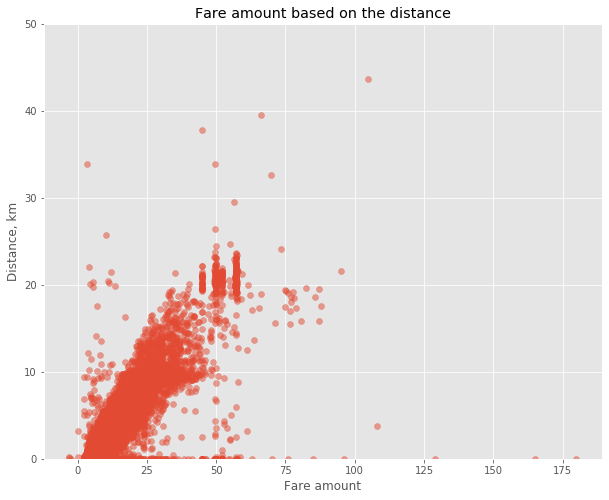

In [10]:
# Calculate the ride distance
train['distance_km'] = haversine_distance(train)

# Draw a scatterplot
plt.scatter(x=train['fare_amount'], y=train['distance_km'], alpha=0.5);
plt.xlabel('Fare amount');
plt.ylabel('Distance, km');
plt.title('Fare amount based on the distance');

# Limit on the distance
plt.ylim(0, 50);

### EDA plots II
Another idea that comes to mind is that the price of a ride could change during the day.

Your goal is to plot the median fare amount for each hour of the day as a simple line plot. The hour feature is calculated for you. Don't worry if you do not know how to work with the date features. We will explore them in the chapter on Feature Engineering.

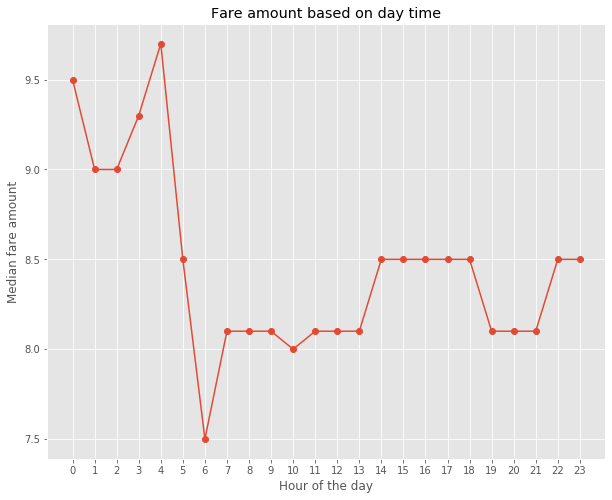

In [11]:
# Create hour feature
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train['hour'] = train.pickup_datetime.dt.hour

# Find median fare_amount for each hour
hour_price = train.groupby('hour', as_index=False)['fare_amount'].median()

# Plot the line plot
plt.plot(hour_price['hour'], hour_price['fare_amount'], marker='o');
plt.xlabel('Hour of the day');
plt.ylabel('Median fare amount');
plt.title('Fare amount based on day time');
plt.xticks(range(24));

We see that prices are a bit higher during the night. It is a good indicator that we should include the `"hour"` feature in the final model, or at least add a binary feature `"is_night"`. 

## Local Validation
- Holdout set
![holdout](image/holdout_set.png)
- K-fold cross-validation
![kfold_cv](image/kfold_cv.png)
- Stratified K-fold
![stratified](image/stratified_kfold.png)

### K-fold cross-validation
You will start by getting hands-on experience in the most commonly used K-fold cross-validation.

The data you'll be working with is from the "Two sigma connect: rental listing inquiries" Kaggle competition. The competition problem is a multi-class classification of the rental listings into 3 classes: low interest, medium interest and high interest. For faster performance, you will work with a subsample consisting of 1,000 observations.

You need to implement a K-fold validation strategy and look at the sizes of each fold obtained.

In [12]:
train = pd.read_csv('./dataset/twosigma_rental_train.csv')

In [13]:
from sklearn.model_selection import KFold

# Create a KFold object
kf = KFold(n_splits=3, shuffle=True, random_state=123)

# Loop through each split
fold = 0
for train_index, test_index in kf.split(train):
    # Obtain training and test folds
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    print("Fold: {}".format(fold))
    print("CV train shape: {}".format(cv_train.shape))
    print("Medium interest listings in CV train: {}\n".format(
        sum(cv_train.interest_level == 'medium')
    ))
    fold += 1

Fold: 0
CV train shape: (666, 9)
Medium interest listings in CV train: 175

Fold: 1
CV train shape: (667, 9)
Medium interest listings in CV train: 165

Fold: 2
CV train shape: (667, 9)
Medium interest listings in CV train: 162



### Stratified K-fold
As you've just noticed, you have a pretty different target variable distribution among the folds due to the random splits. It's not crucial for this particular competition, but could be an issue for the classification competitions with the highly imbalanced target variable.

To overcome this, let's implement the stratified K-fold strategy with the stratification on the target variable.

In [14]:
from sklearn.model_selection import StratifiedKFold

# Create a StratifiedKFold object
str_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# Loop through each split
fold = 0
for train_index, test_index in str_kf.split(train, train['interest_level']):
    # Obtain training and test folds
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    print('Fold: {}'.format(fold))
    print('CV train shape: {}'.format(cv_train.shape))
    print('Medium interest listings in CV train: {}\n'.format(
        sum(cv_train.interest_level == 'medium')
    ))
    fold += 1

Fold: 0
CV train shape: (666, 9)
Medium interest listings in CV train: 167

Fold: 1
CV train shape: (667, 9)
Medium interest listings in CV train: 167

Fold: 2
CV train shape: (667, 9)
Medium interest listings in CV train: 168



## Validation usage
- Data Leakage
    - Leak in **features** - using data that will not be available in the real setting
    - Leak in **validation strategy** - validation strategy differs from the real-world situation
- Time K-fold cross-validation
    - Time-series data cannot use with KFold Cross validation
![time kfold](image/time_kfold.png)

### Time K-fold
Remember the "Store Item Demand Forecasting Challenge" where you are given store-item sales data, and have to predict future sales?

It's a competition with time series data. So, time K-fold cross-validation should be applied. Your goal is to create this cross-validation strategy and make sure that it works as expected.

In [15]:
train = pd.read_csv('./dataset/demand_forecasting_train_1_month.csv')

In [16]:
from sklearn.model_selection import TimeSeriesSplit

# Create TimeSeriesSplit object
time_kfold = TimeSeriesSplit(n_splits=3)

# sort train data by date
train = train.sort_values('date')

# Iterate through each split
fold = 0
for train_index, test_index in time_kfold.split(train):
    cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
    
    print('Fold :', fold)
    print('Train date range: from {} to {}'.format(cv_train.date.min(), cv_train.date.max()))
    print('Test date range: from {} to {}\n'.format(cv_test.date.min(), cv_test.date.max()))
    fold += 1

Fold : 0
Train date range: from 2017-12-01 to 2017-12-08
Test date range: from 2017-12-08 to 2017-12-16

Fold : 1
Train date range: from 2017-12-01 to 2017-12-16
Test date range: from 2017-12-16 to 2017-12-24

Fold : 2
Train date range: from 2017-12-01 to 2017-12-24
Test date range: from 2017-12-24 to 2017-12-31



### Overall validation score
Now it's time to get the actual model performance using cross-validation! How does our store item demand prediction model perform?

Your task is to take the Mean Squared Error (MSE) for each fold separately, and then combine these results into a single number.

For simplicity, you're given `get_fold_mse()` function that for each cross-validation split fits a Random Forest model and returns a list of MSE scores by fold. 

In [17]:
from sklearn.ensemble import RandomForestRegressor

def get_fold_mse(train, kf):
    mse_scores = []
    
    for train_index, test_index in kf.split(train):
        fold_train, fold_test = train.loc[train_index], train.loc[test_index]

        # Fit the data and make predictions
        # Create a Random Forest object
        rf = RandomForestRegressor(n_estimators=10, random_state=123)

        # Train a model
        rf.fit(X=fold_train[['store', 'item']], y=fold_train['sales'])

        # Get predictions for the test set
        pred = rf.predict(fold_test[['store', 'item']])
    
        fold_score = round(mean_squared_error(fold_test['sales'], pred), 5)
        mse_scores.append(fold_score)
        
    return mse_scores

In [18]:
# Initialize 3-fold time cross-validation
kf = TimeSeriesSplit(n_splits=3)

# Get MSE scores for each cross-validation split
mse_scores = get_fold_mse(train, kf)

print('Mean validation MSE: {:.5f}'.format(np.mean(mse_scores)))
print('MSE by fold: {}'.format(mse_scores))
print('Overall Validation MSE: {:.5f}'.format(np.mean(mse_scores) + np.std(mse_scores)))

Mean validation MSE: 955.49186
MSE by fold: [890.30336, 961.65797, 1014.51424]
Overall Validation MSE: 1006.38784
